In [13]:
import pandas as pd
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation,concatenate, Attention, Bidirectional,GlobalAveragePooling1D
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import keras_tuner as kt
import math
from datetime import datetime, timedelta
from scipy.stats import norm

In [2]:
start_date = '2016-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
#end_date = '2024-01-10'
print(end_date)
data = yf.download("ETH-USD", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
display(data)
dates = data['Date']
data = data[['Close', 'High', 'Low', 'Volume']]


2024-01-14


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
2252,2024-01-09,2332.868164,2369.641602,2243.219238,2344.827148,2344.827148,14891130716
2253,2024-01-10,2344.923584,2626.976807,2341.943115,2582.103516,2582.103516,29042100476
2254,2024-01-11,2584.171631,2687.779053,2567.993652,2619.619141,2619.619141,22575246883
2255,2024-01-12,2619.177002,2710.421875,2460.925537,2524.460205,2524.460205,23623839263


In [3]:
Xscaler = MinMaxScaler()
Xdata = Xscaler.fit_transform(np.array(data))
Xdata.shape
Yscaler = MinMaxScaler()
Ydata = Yscaler.fit_transform(np.array([data['Close']]).transpose())

In [4]:
Xtrain_data, Xtest_data = train_test_split(Xdata, test_size=0.3, shuffle=False)
Ytrain_data, Ytest_data = train_test_split(Ydata, test_size=0.3, shuffle=False)
display(Xtrain_data.shape)
display(Xtest_data.shape)

(1579, 4)

(678, 4)

In [5]:
def build_timeseries(Xdata, Ydata, time_step):
    dim_0 = Xdata.shape[0] - time_step
    dim_1 = Xdata.shape[1]

    x = np.zeros((dim_0, time_step, dim_1))
    y = np.zeros((Ydata.shape[0] - time_step,))

    for i in range(dim_0):
        x[i] = Xdata[i:time_step+i]
        y[i] = Ydata[time_step+i]
    return x, y

In [6]:
time_step = 100
display(Ytrain_data.transpose()[0])
X_train, Y_train = build_timeseries(Xtrain_data, Ytrain_data.transpose()[0], time_step)
X_test, Y_test = build_timeseries(Xtest_data, Ytest_data.transpose()[0], time_step)

X_train = X_train.reshape((X_train.shape[0], time_step, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], time_step, X_test.shape[2]))
display(X_train.shape)
display(Y_train.shape)
display(X_test)
display(Y_test.shape)

array([0.0500395 , 0.0454642 , 0.04872747, ..., 0.53573732, 0.54582135,
       0.52259824])

(1479, 100, 4)

(1479,)

array([[[0.51048556, 0.53150396, 0.51190006, 0.16661304],
        [0.5271903 , 0.52697307, 0.51927004, 0.15860962],
        [0.5595598 , 0.55685646, 0.53737065, 0.16159959],
        ...,
        [0.2878536 , 0.3025911 , 0.2919726 , 0.27239471],
        [0.23695575, 0.28366472, 0.23712379, 0.53112842],
        [0.2384533 , 0.24283004, 0.21830126, 0.39000278]],

       [[0.5271903 , 0.52697307, 0.51927004, 0.15860962],
        [0.5595598 , 0.55685646, 0.53737065, 0.16159959],
        [0.53381096, 0.55005715, 0.53576077, 0.15109189],
        ...,
        [0.23695575, 0.28366472, 0.23712379, 0.53112842],
        [0.2384533 , 0.24283004, 0.21830126, 0.39000278],
        [0.24301011, 0.23953353, 0.20341138, 0.44023071]],

       [[0.5595598 , 0.55685646, 0.53737065, 0.16159959],
        [0.53381096, 0.55005715, 0.53576077, 0.15109189],
        [0.52355549, 0.5366254 , 0.5289639 , 0.14023994],
        ...,
        [0.2384533 , 0.24283004, 0.21830126, 0.39000278],
        [0.24301011, 0.239533

(578,)

In [7]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [8]:
lstm_model = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 50,batch_size = 50, verbose = 1)

Epoch 1/50

30/30 [==============================] - 7s 99ms/step - loss: 0.0088 - val_loss: 9.2197e-04
Epoch 2/50
30/30 [==============================] - 2s 59ms/step - loss: 0.0022 - val_loss: 9.8779e-04
Epoch 3/50
30/30 [==============================] - 2s 62ms/step - loss: 0.0018 - val_loss: 8.5380e-04
Epoch 4/50
30/30 [==============================] - 2s 66ms/step - loss: 0.0019 - val_loss: 7.1542e-04
Epoch 5/50
30/30 [==============================] - 2s 67ms/step - loss: 0.0016 - val_loss: 6.7472e-04
Epoch 6/50
30/30 [==============================] - 2s 65ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 7/50
30/30 [==============================] - 2s 67ms/step - loss: 0.0013 - val_loss: 6.0935e-04
Epoch 8/50
30/30 [==============================] - 2s 69ms/step - loss: 0.0012 - val_loss: 5.8372e-04
Epoch 9/50
30/30 [==============================] - 2s 71ms/step - loss: 0.0011 - val_loss: 7.6584e-04
Epoch 10/50
30/30 [==============================] - 2s 66ms/step - loss: 0.

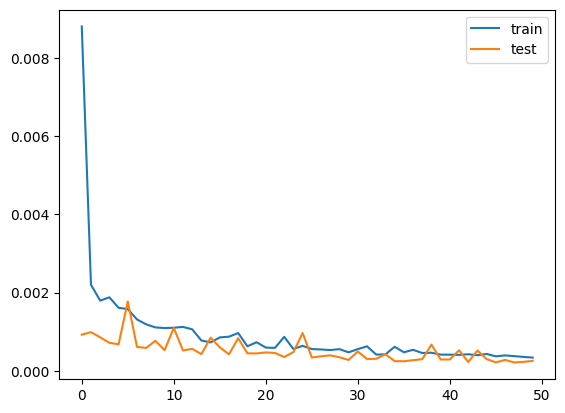

In [9]:
plt.plot(lstm_model.history['loss'], label='train')
plt.plot(lstm_model.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
# make a prediction
yhat = model.predict(X_test)
# invert scaling for forecast
inv_yhat = Yscaler.inverse_transform(yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = Y_test.reshape((len(Y_test), 1))
inv_y = Yscaler.inverse_transform(test_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

19/19 [==============================] - 1s 16ms/step
Test RMSE: 75.162


19/19 [==============================] - 0s 16ms/step


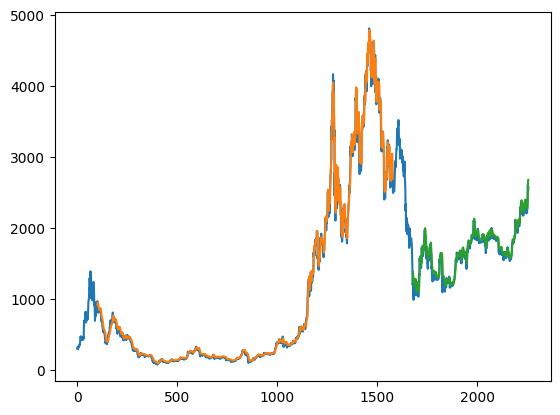

In [11]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
look_back = 100
trainPredictPlot = np.empty_like(Ydata)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict
testPredictPlot = np.empty_like(Ydata)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 : len(Ydata),:] = test_predict
plt.plot(Yscaler.inverse_transform(Ydata))
plt.plot(Yscaler.inverse_transform(trainPredictPlot))
plt.plot(Yscaler.inverse_transform(testPredictPlot))
plt.show()

In [18]:
print("Accuracy: "'{:.2f}%'.format(100-mean_absolute_percentage_error(Y_test, test_predict)*100))

Accuracy: 96.22%


In [13]:
prediction_data = np.array([X_test[-1]])
display(prediction_data.shape)
prediction = model.predict(prediction_data)
prediction = Yscaler.inverse_transform(prediction)[0][0]
print("Prediction for: ", end_date, "        CLOSE: ", prediction)

(1, 100, 4)

1/1 [==============================] - 0s 38ms/step
Prediction for:  2024-01-11         CLOSE:  2257.1067


In [14]:
results = []
runs = 30
prediction_data = np.array([X_test[-1]])
display(prediction_data.shape)
for i in range(runs):
    print("RUN: ", i+1)
    model = Sequential()
    model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(50,return_sequences = True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error',optimizer = 'adam')
    lstm_model = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 25,batch_size = 50, verbose = 1)
    prediction = model.predict(prediction_data)
    prediction = Yscaler.inverse_transform(prediction)[0][0]
    print("Prediction for: ", end_date, "        CLOSE: ", prediction)
    results.append(prediction)

lastclose = Yscaler.inverse_transform([Ydata[-1]])[0][0]
adjresults = np.array([x - lastclose for x in results])
mu = adjresults.mean()
std = adjresults.std()

fig, ax = plt.subplots()
xmin, xmax = plt.xlim()
diff = pd.DataFrame(adjresults) 
kde = diff.plot.kde(ax=ax, legend = False)
diff.plot.hist(density=True, ax=ax, bins=20)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
plt.title(title)
plt.show() 

(1, 100, 4)

RUN:  1
Epoch 1/25
30/30 [==============================] - 9s 121ms/step - loss: 0.0199 - val_loss: 0.0011
Epoch 2/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 3/25
30/30 [==============================] - 2s 78ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 4/25
30/30 [==============================] - 2s 75ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 5/25
30/30 [==============================] - 2s 80ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 6/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0016 - val_loss: 7.7662e-04
Epoch 7/25
30/30 [==============================] - 2s 80ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/25
30/30 [==============================] - 2s 82ms/step - loss: 0.0014 - val_loss: 8.0138e-04
Epoch 10/25
30/30 [==============================] - 2s 79ms/step - loss: 0.0012 - val_loss:

KeyboardInterrupt: 

In [ ]:
def LSTMPrediction(time_step = 10, runs = 30, end_date=datetime.strftime(today, '%Y-%m-%d')):
    #Data Pull
    start_date = '2016-01-01'
    today = datetime.now()
    print("End Date: ", end_date)
    data = yf.download("ETH-USD", start=start_date, end=end_date) #Displays till yesterday as today is not complete
    data = data.reset_index()
    data = data[['Close', 'Open', 'High', 'Low', 'Volume']]

    #Data Scaling
    Xscaler = MinMaxScaler()
    Xdata = Xscaler.fit_transform(np.array(data))
    Xdata.shape
    Yscaler = MinMaxScaler()
    Ydata = Yscaler.fit_transform(np.array([data['Close']]).transpose())

    Xtrain_data, Xtest_data = train_test_split(Xdata, test_size=0.3, shuffle=False)
    Ytrain_data, Ytest_data = train_test_split(Ydata, test_size=0.3, shuffle=False)
    
    def build_timeseries(Xdata, Ydata, time_step):
        dim_0 = Xdata.shape[0] - time_step
        dim_1 = Xdata.shape[1]

        x = np.zeros((dim_0, time_step, dim_1))
        y = np.zeros((Ydata.shape[0] - time_step,))

        for i in range(dim_0):
            x[i] = Xdata[i:time_step+i]
            y[i] = Ydata[time_step+i]
        return x, y

    
    X_train, Y_train = build_timeseries(Xtrain_data, Ytrain_data.transpose()[0], time_step)
    X_test, Y_test = build_timeseries(Xtest_data, Ytest_data.transpose()[0], time_step)

    X_train = X_train.reshape((X_train.shape[0], time_step, X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], time_step, X_test.shape[2]))

    results = []
    prediction_data = np.array([X_test[-1]])
    for i in range(runs):
        print("RUN: ", i+1)
        model = Sequential()
        model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],X_train.shape[2])))
        model.add(LSTM(50,return_sequences = True))
        model.add(LSTM(50))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error',optimizer = 'adam')
        lstm_model = model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 25,batch_size = 50, verbose = 1)
        prediction = model.predict(prediction_data)
        prediction = Yscaler.inverse_transform(prediction)[0][0]
        print("Prediction for: ", end_date, "        CLOSE: ", prediction)
        results.append(prediction)

    lastclose = Yscaler.inverse_transform([Ydata[-1]])[0][0]
    adjresults = np.array([x - lastclose for x in results])
    mu = adjresults.mean()
    std = adjresults.std()

    fig, ax = plt.subplots()
    xmin, xmax = plt.xlim()
    diff = pd.DataFrame(adjresults) 
    kde = diff.plot.kde(ax=ax, legend = False)
    diff.plot.hist(density=True, ax=ax, bins=20)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
    plt.title(title)
    plt.show()
    return

In [ ]:
LSTMPrediction()

NameError: name 'LSTMPrediction' is not defined

In [ ]:
start_date = "2016-01-01"
critical_date = "2023-12-20" # news data points do not exist beyond (earlier) than this date
today = datetime.now()
end_date = datetime.strftime(today, "%Y-%m-%d")
data = yf.download("ETH-USD", start=start_date, end=critical_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dates = data["Date"]

